In [1]:
import pynbody
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy import optimize

f9=pynbody.load("snapshot_099")
f9.physical_units()
h9=f9.halos()

# Boltzmann constant
kB=pynbody.array.SimArray(np.random.rand(1))
kB[0]=1.38e-23
kB.sim=f9
kB.units='J K**-1'
# A simpler way?
    
# Planck constant
h=pynbody.array.SimArray(np.random.rand(1))
h[0]=6.63e-34
h.sim=f9
h.units='J s'

normalize=np.random.normal(size=(len(f9),3))

In [2]:
def entropy_iso(f):
    '''
    f is a snapshot
    returns SimArray of entropy density and entropy
    '''
    
    pynbody.config['sph']['smooth-particles']=256
    
    
    ###
    density=f.dm['rho']
    print('The density has been calculated')
    ###
    
    ######################################################################
    # Normalization Process

    norm1=f.dm.kdtree.sph_mean(normalize)
    norm2=f.dm.kdtree.sph_mean((normalize-norm1)**2)
    
    nx=norm2[:,0]
    ny=norm2[:,1]
    nz=norm2[:,2]
    
    norm=(nx+ny+nz)/3
    
    ######################################################################
    # Velocity Dispersion
    
    offset=np.mean(f.dm['vel'].in_units('m s**-1'))
    vel=f.dm['vel'].in_units('m s**-1')-offset
    
    vel_disp=f.dm.kdtree.sph_mean((vel-f.dm.kdtree.sph_mean(vel))**2)
    
    vx_disp=vel_disp[:,0]
    vy_disp=vel_disp[:,1]
    vz_disp=vel_disp[:,2]

    v_disp=(vx_disp+vy_disp+vz_disp)/3
    
    v_disp=v_disp/norm
    print('the velocity dispersions has been calculated')

    ######################################################################
    # Scaling Process
    # Adopt a value of 40Gev for DM particles(Geringer-Sameth & Koushiappas 2011)
    
    mass_dm=pynbody.array.SimArray(np.random.rand(1))
    mass_dm[0]=40000
    mass_dm.sim=f
    mass_dm.units='MeV c**-2'
    
    ######################################################################
    # Scaled Number density
    
    n_density=f.dm['rho'].in_units('kg m**-3')/mass_dm.in_units('kg')
    
    ######################################################################
    # Sackur-Tetrode Equation
    
    a=np.sqrt(v_disp.in_units('m**2 s**-2'))**3/n_density
    b=a*((2*np.pi)**(3/2))*(mass_dm.in_units('kg')**3)/(h**3)*(np.e**(5/2))
    sv=kB*n_density*np.log(b.in_units('1'))
    
    ######################################################################
    # Entropy
    
    volume=mass_dm/f.dm['rho']
    S=volume*sv
    
    ######################################################################
    # Storing
    
    f.dm['Q_iso']=1/a*mass_dm.in_units('kg')
    f.dm['S_iso']=S
    f.dm['sv_iso']=sv

In [3]:
def entropy_ani(f):
    '''
    f is a snapshot
    returns SimArray of entropy density and entropy
    '''
    
    pynbody.config['sph']['smooth-particles']=256
    
    ###
    density=f.dm['rho']
    print('The density has been calculated')
    ###
    
    ######################################################################
    # Normalization Process
    
    dnorm=normalize-f.dm.kdtree.sph_mean(normalize)
    
    dnormx=dnorm[:,0]
    dnormy=dnorm[:,1]
    dnormz=dnorm[:,2]
    
    n2_xx=f.dm.kdtree.sph_mean(dnormx**2)
    n2_yy=f.dm.kdtree.sph_mean(dnormy**2)
    n2_zz=f.dm.kdtree.sph_mean(dnormz**2)
    
    n2_xy=f.dm.kdtree.sph_mean(dnormx*dnormy)
    n2_yz=f.dm.kdtree.sph_mean(dnormy*dnormz)
    n2_zx=f.dm.kdtree.sph_mean(dnormz*dnormx)
    
    norm6=n2_xx*(n2_yy*n2_zz-n2_yz**2)-n2_xy*(n2_xy*n2_zz-n2_yz*n2_zx)+n2_zx*(n2_xy*n2_yz-n2_yy*n2_zx)
    norm=norm6**(1/3)
    
    ######################################################################
    # Velocity Dispersion
    
    offset=np.mean(f.dm['vel'].in_units('m s**-1'))
    vel=f.dm['vel'].in_units('m s**-1')-offset
    
    dvel=vel-f.dm.kdtree.sph_mean(vel)
    dvx=dvel[:,0]
    dvy=dvel[:,1]
    dvz=dvel[:,2]
    
    disp_xx=f.dm.kdtree.sph_mean(dvx**2)
    disp_yy=f.dm.kdtree.sph_mean(dvy**2)
    disp_zz=f.dm.kdtree.sph_mean(dvz**2)
    
    disp_xy=f.dm.kdtree.sph_mean(dvx*dvy)
    disp_yz=f.dm.kdtree.sph_mean(dvy*dvz)
    disp_zx=f.dm.kdtree.sph_mean(dvz*dvx)
    
    det_disp=disp_xx*(disp_yy*disp_zz-disp_yz**2)-disp_xy*(disp_xy*disp_zz-disp_yz*disp_zx)+disp_zx*(disp_xy*disp_yz-disp_yy*disp_zx)
    det=det_disp**(1/3)
    
    det=det/norm
    det.units='m**2 s**-2'
    
    print('the velocity dispersions has been calculated')

    ######################################################################
    # Scaling Process
    # Adopt a value of 40Gev for DM particles(Geringer-Sameth & Koushiappas 2011)
    
    mass_dm=pynbody.array.SimArray(np.random.rand(1))
    mass_dm[0]=40000
    mass_dm.sim=f
    mass_dm.units='MeV c**-2'
    
    ######################################################################
    # Scaled Number density
    
    n_density=f.dm['rho'].in_units('kg m**-3')/mass_dm.in_units('kg')
    
    ######################################################################
    # Sackur-Tetrode Equation
    
    c=np.sqrt(det.in_units('m**2 s**-2'))**3/n_density.in_units('m**-3')
    d=((2*np.pi)**(3/2))*(np.e**(5/2))*(mass_dm.in_units('kg')**3)/(h**3)*c
    d.units='1'
    sv=kB*n_density*np.log(d.in_units('1'))
    
    ######################################################################
    # Entropy
    
    volume=mass_dm/f.dm['rho']
    S=volume*sv
    
    ######################################################################
    # Storing
    
    f.dm['Q_ani']=1/c*mass_dm.in_units('kg')
    f.dm['S_ani']=S
    f.dm['sv_ani']=sv

In [4]:
entropy_iso(f9)
entropy_ani(f9)

The density has been calculated
the velocity dispersions has been calculated
The density has been calculated
the velocity dispersions has been calculated


In [5]:
def profile(h):
    centering=pynbody.analysis.halo.center(h,vel=False)
    
    h_f9=f9.properties['h']
    a_f9=f9.properties['a']
    rc=float(h.properties['rcrit_200'])/a_f9*h_f9*1000
    
    h.physical_units()
    
    p=pynbody.analysis.profile.Profile(h.d,max=2*rc,ndim=3)
    
    centering.revert()
    
    return p

In [6]:
def  power(h):
    h.physical_units()
    p=profile(h)
    
    def f_fitting(x,A,B):
        return A*x+B
    
    fit_r=np.log(p['rbins'])[4:]
    fit_Q_iso=np.log(p['Q_iso'].in_units('kg s**3 m**-6'))[4:]
    fit_Q_ani=np.log(p['Q_ani'].in_units('kg s**3 m**-6'))[4:]
    
    A_iso,B_iso=optimize.curve_fit(f_fitting,fit_r,fit_Q_iso)[0]
    A_ani,B_ani=optimize.curve_fit(f_fitting,fit_r,fit_Q_ani)[0]
    
    return A_iso, A_ani, B_iso, B_ani

In [7]:
def halo_Q(h):
    p_h_1=profile(h)
    x_h_1=np.linspace(np.min(np.log(p_h_1['rbins'])),np.max(np.log(p_h_1['rbins'])),100)
    
    lw=3
    fs=20
    
    fig1=plt.figure(figsize=(15,8))
    
    plt.plot(np.log10(p_h_1['rbins']),np.log10(p_h_1['Q_iso'].in_units('kg s**3 m**-6')),color='blue',label='Isotropic',linewidth=lw)
    plt.plot(np.log10(p_h_1['rbins']),np.log10(p_h_1['Q_ani'].in_units('kg s**3 m**-6')),color='orange',label='Anisotropic',linewidth=lw)
    plt.xlabel('log_{10}(r/kpc)',fontsize=fs)
    plt.ylabel('log_{10}(Q)',fontsize=fs)
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)
    plt.legend(fontsize=fs,loc='upper center')
    plt.ylim([-41.,-37.3])
    plt.xlim([0.7,3])
    
    plt.plot(1.35*np.ones(1000),np.linspace(-41,-37.3,1000),linestyle='--',color='red',linewidth=2)
    plt.plot(2.58*np.ones(1000),np.linspace(-41,-37.3,1000),linestyle='--',color='red',linewidth=2)
    
    plt.text(0.85,-40.8,'softening', fontsize=fs, color='red')
    plt.text(1.7,-40.8,'"proper" behaviour', fontsize=fs, color='red')
    plt.text(2.6,-40.8,'substructures', fontsize=fs, color='red')
    
    plt.savefig('halo_Q.pdf')

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/pynbody/array.py:865: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.base[self._reexpress_index(item)]


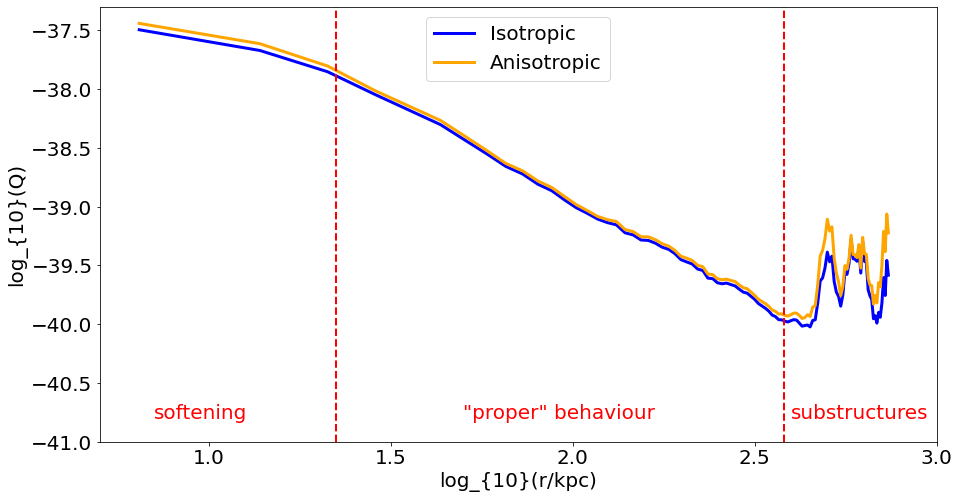

In [8]:
halo_Q(h9[3])